<a href="https://colab.research.google.com/github/ravinnd3/Predictive-Maintenance_variational_AutoEncoder/blob/main/Predictive_Maintenance_variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os

import kagglehub


import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format

LOAD DATA

In [3]:

# Download latest version
dataset_path = kagglehub.dataset_download("hiimanshuagarwal/predictive-maintenance-dataset")

destination_path = "/content/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the downloaded dataset to the destination path
# We use shell command for simplicity, you could also use shutil.copytree
!cp -r "{dataset_path}/." "{destination_path}/"

print(f"Dataset copied to: {destination_path}")

# List files in the destination directory to confi

100%|██████████| 1.72M/1.72M [00:01<00:00, 1.55MB/s]

Extracting files...


Dataset copied to: /content/


In [4]:
df = pd.read_csv('/content/predictive_maintenance_dataset.csv')
df.head(10)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
5,1/1/2015,S1F01TD5,0,68837488,0,0,41,6,413535,0,0,1
6,1/1/2015,S1F01XDJ,0,227721632,0,0,0,8,402525,0,0,0
7,1/1/2015,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3
8,1/1/2015,S1F02A0J,0,8217840,0,1,0,14,311869,0,0,0
9,1/1/2015,S1F02DZ2,0,116440096,0,378,9,9,407905,0,0,170


ANALYSIS - EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [6]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,"124,494.0000","124,494.0000","124,494.0000","124,494.0000","124,494.0000","124,494.0000","124,494.0000","124,494.0000","124,494.0000","124,494.0000"
mean,0.0009,"122,388,103.2421",159.4927,9.9409,1.7411,14.2227,"260,172.6577",0.2925,0.2925,13.0138
std,0.0292,"70,459,334.2164","2,179.6778",185.7481,22.9085,15.9430,"99,151.0785",7.4369,7.4369,275.6612
min,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,8.0000,0.0000,0.0000,0.0000
25%,0.0000,"61,284,762.0000",0.0000,0.0000,0.0000,8.0000,"221,452.0000",0.0000,0.0000,0.0000
50%,0.0000,"122,797,388.0000",0.0000,0.0000,0.0000,10.0000,"249,799.5000",0.0000,0.0000,0.0000
75%,0.0000,"183,309,640.0000",0.0000,0.0000,0.0000,12.0000,"310,266.0000",0.0000,0.0000,0.0000
max,1.0000,"244,140,480.0000","64,968.0000","24,929.0000","1,666.0000",98.0000,"689,161.0000",832.0000,832.0000,"70,000.0000"


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [9]:
# Extracts the day of the week (0-6, with 7 representing Sunday).
df['week_day'] = df.date.dt.weekday

# Replaces 0 with 7 to represent Sunday consistently
df['week_day'] = df['week_day'].replace(0, 7)



In [10]:
len(df['device'].unique())

1169

In [11]:
device_with_failure = df['device'].where(df['failure']==1).unique()
len(device_with_failure)

107

Out of 1169 devices only 107 devices been fault.

In [12]:
df[(df['device']=='S1F01085')]

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,week_day
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,2015,1,1,3
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,2015,1,2,4
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,2015,1,3,5
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,2015,1,4,6
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,2015,1,5,7
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,0,7,2015,1,6,1


In [13]:
df[df['device']=='S1F01XDJ']

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,week_day
6,2015-01-01,S1F01XDJ,0,227721632,0,0,0,8,402525,0,0,0,2015,1,1,3
1169,2015-01-02,S1F01XDJ,0,2211760,0,0,0,8,403892,0,0,0,2015,1,2,4
2332,2015-01-03,S1F01XDJ,0,27064120,0,0,0,8,405205,0,0,0,2015,1,3,5
3495,2015-01-04,S1F01XDJ,0,45476376,0,0,0,8,406531,0,0,0,2015,1,4,6
4657,2015-01-05,S1F01XDJ,0,67532472,0,0,0,8,407851,0,0,0,2015,1,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69330,2015-04-12,S1F01XDJ,0,6252720,0,0,0,8,426706,0,0,0,2015,4,12,6
69733,2015-04-13,S1F01XDJ,0,234345904,0,0,0,8,426706,0,0,0,2015,4,13,7
70136,2015-04-14,S1F01XDJ,0,88665912,0,0,0,8,426727,0,0,0,2015,4,14,1
70539,2015-04-15,S1F01XDJ,0,221300216,0,0,0,8,427985,0,0,0,2015,4,15,2


In [14]:
df['activedays'] = df.date - df.date[0]

In [15]:
df

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,week_day,activedays
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,2015,1,1,3,0 days
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2015,1,1,3,0 days
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2015,1,1,3,0 days
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2015,1,1,3,0 days
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2015,1,1,3,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,2015,11,2,7,305 days
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,2015,11,2,7,305 days
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,2015,11,2,7,305 days
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,2015,11,2,7,305 days


In [16]:
df[(df['device']=='S1F01085')]

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,week_day,activedays
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,2015,1,1,3,0 days
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,2015,1,2,4,1 days
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,2015,1,3,5,2 days
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,2015,1,4,6,3 days
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,2015,1,5,7,4 days
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,0,7,2015,1,6,1,5 days


In [17]:
def str_to_num(str):
    return str.split(' ')[0]

In [18]:
df.activedays = df.activedays.astype('str')
df.activedays = df.activedays.apply(str_to_num)
df.activedays = df.activedays.astype('int')

In [19]:
df

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,week_day,activedays
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,2015,1,1,3,0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2015,1,1,3,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2015,1,1,3,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2015,1,1,3,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2015,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,2015,11,2,7,305
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,2015,11,2,7,305
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,2015,11,2,7,305
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,2015,11,2,7,305


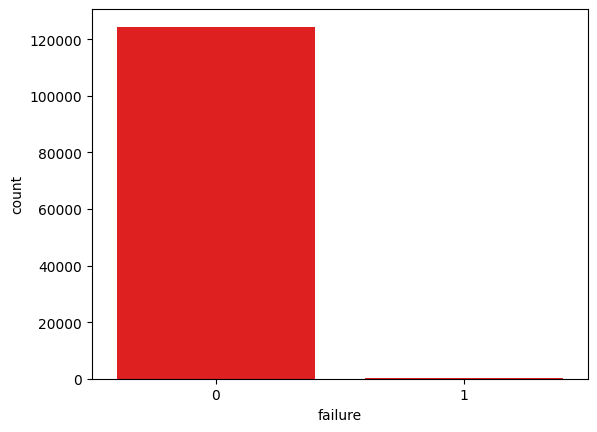

In [20]:
sns.barplot(df['failure'].value_counts(), color='red')
plt.show()

In [21]:
df['failure'].value_counts()

,count
failure,
0,124388
1,106


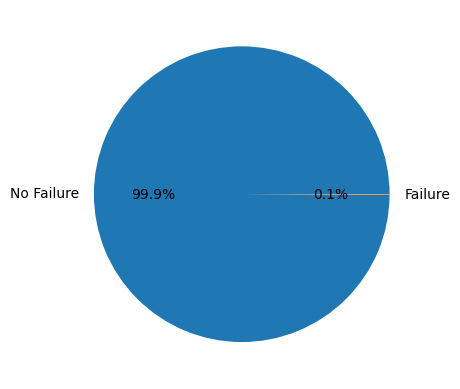

In [22]:
plt.pie(df['failure'].value_counts(), labels=['No Failure', 'Failure'], autopct='%1.1f%%')
plt.show()

Determining RUL (remaining useful life)

In [23]:
df_RUL = df.groupby('device').agg({'activedays': 'max'})

In [24]:
df_RUL.rename(columns={'activedays': 'Life_span'}, inplace=True)

Only data is there for 1 year i.e 2015

In [25]:
df['month'].value_counts()

,count
month,
1,25032
3,19833
2,19500
4,12012
5,11330
7,10531
6,10469
8,8346
9,4470


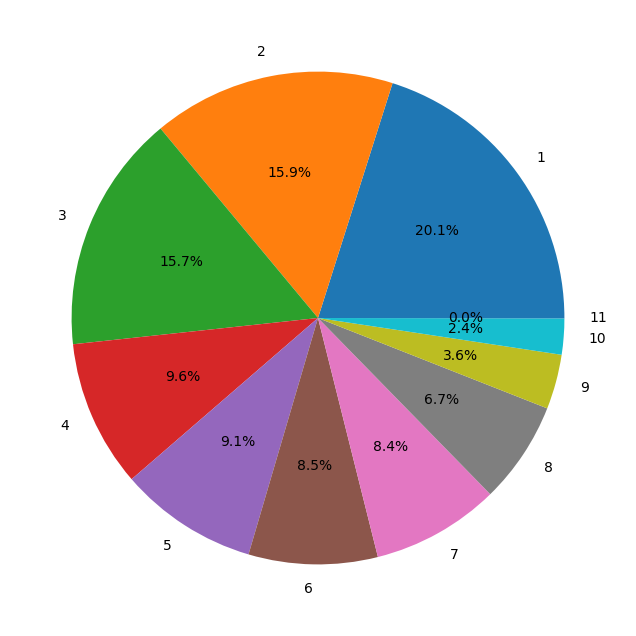

In [26]:
plt.figure(figsize=(8,8))
plt.pie(df['month'].value_counts(), labels=df['month'].unique(), autopct='%1.1f%%')
plt.show()

FEATURE ENGINEERING

In [27]:
normal_df = df[df['failure'] == 0]
#preserving devices and RUL
normal_df['RUL'] = normal_df['activedays'] - normal_df['activedays'].max()

normal_df.drop(columns=['date', 'failure','day','month','year'], axis=1, inplace=True)

/tmp/ipython-input-749581296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df['RUL'] = normal_df['activedays'] - normal_df['activedays'].max()
/tmp/ipython-input-749581296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df.drop(columns=['date', 'failure','day','month','year'], axis=1, inplace=True)


In [28]:
normal_df

,device,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,week_day,activedays,RUL
0,S1F01085,215630672,55,0,52,6,407438,0,0,7,3,0,-305
1,S1F0166B,61370680,0,3,0,6,403174,0,0,0,3,0,-305
2,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,3,0,-305
3,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,3,0,-305
4,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,3,0,-305
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,Z1F0MA1S,18310224,0,0,0,10,353705,8,8,0,7,305,0
124490,Z1F0Q8RT,172556680,96,107,4,11,332792,0,0,13,7,305,0
124491,Z1F0QK05,19029120,4832,0,0,11,350410,0,0,0,7,305,0
124492,Z1F0QL3N,226953408,0,0,0,12,358980,0,0,0,7,305,0


In [29]:
def remove_outliers_iqr(df, features):
    df_clean = df.copy()
    for feature in features:
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df_clean[(df_clean[feature] < (Q1 - 1.5 * IQR)) | (df_clean[feature] > (Q3 + 1.5 * IQR))]
        df_clean = df_clean[~df_clean.index.isin(outliers.index)]
    return df_clean


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   metric1     124494 non-null  int64         
 4   metric2     124494 non-null  int64         
 5   metric3     124494 non-null  int64         
 6   metric4     124494 non-null  int64         
 7   metric5     124494 non-null  int64         
 8   metric6     124494 non-null  int64         
 9   metric7     124494 non-null  int64         
 10  metric8     124494 non-null  int64         
 11  metric9     124494 non-null  int64         
 12  year        124494 non-null  int32         
 13  month       124494 non-null  int32         
 14  day         124494 non-null  int32         
 15  week_day    124494 non-null  int32         
 16  ac

In [31]:
features = normal_df.select_dtypes(include=np.number).columns
df_no_outliers = remove_outliers_iqr(normal_df, features)


In [32]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_no_outliers.drop('device', axis=1))

In [33]:
# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(X_scaled, f)

In [34]:
numeric_cols = df_no_outliers.drop('device', axis=1).columns
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols, index=df_no_outliers.index)
X_combined = pd.concat([df_no_outliers['device'], X_scaled_df], axis=1)
print(X_combined.head())

      device  metric1  metric2  metric3  metric4  metric5  metric6  metric7  \
2   S1F01E6Y   0.7200   0.0000   0.0000   0.0000   0.9251  -0.5133   0.0000   
3   S1F01JE0  -0.6080   0.0000   0.0000   0.0000  -1.2491   2.5380   0.0000   
6   S1F01XDJ   1.4922   0.0000   0.0000   0.0000  -0.5243   2.4028   0.0000   
17  S1F0322R  -1.2487   0.0000   0.0000   0.0000  -0.1620   2.5595   0.0000   
19  S1F035SJ   1.3882   0.0000   0.0000   0.0000  -0.1620   2.1768   0.0000   

    metric8  metric9  week_day  activedays     RUL  
2    0.0000   0.0000   -0.5096     -1.3325 -1.3325  
3    0.0000   0.0000   -0.5096     -1.3325 -1.3325  
6    0.0000   0.0000   -0.5096     -1.3325 -1.3325  
17   0.0000   0.0000   -0.5096     -1.3325 -1.3325  
19   0.0000   0.0000   -0.5096     -1.3325 -1.3325  


MODEL TRRAINING USING VAE

In [35]:
# Convert to Torch tensors
X_tensor = torch.tensor(X_combined.drop('device', axis=1).values, dtype=torch.float32)

input_dim = 11  # number of features in your data after preprocessing


hidden_dim = 64  # chosen hidden size (can be tuned)


11 input features, a good starting point for the latent dimension value is typically between 5 and 10


```Why mean and log variance layers?```

A VAE represents encoded inputs not as a single point but as a distribution in latent space.

During training, a latent vector is sampled from this distribution using the reparameterization trick:

```z=μ+σ⋅ϵ where ϵ~N(0,I)```

This stochastic sampling enables the VAE to regularize the latent space by encouraging encoded representations to follow a prior (usually a unit Gaussian).


```reparameterize```


What each line does:

std = torch.exp(0.5 * logvar)
Converts log-variance to standard deviation.

eps = torch.randn_like(std)
Samples random noise from a standard normal distribution with the same shape as std.

return mu + eps * std

Combines mean, random noise, and standard deviation to get a latent sample from
N
(
μ
,
σ
2
)
N(μ,σ
2
 ) in a differentiable way.

```the loss function```

The loss_function in the VAE consists of two parts—reconstruction loss and KL divergence loss:

In [36]:
# Define VAE Model
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim):
      super(VAE, self).__init__()
      # Encoder
      self.fc1 = nn.Linear(input_dim, 64)
      self.fc21 = nn.Linear(64, latent_dim)  # mean
      self.fc22 = nn.Linear(64, latent_dim)  # log variance
      self.dropout = nn.Dropout(p=0.3)

      # Decoder
      self.fc3 = nn.Linear(latent_dim, 64)
      self.fc4 = nn.Linear(64, input_dim)

  def encode(self, x):
      h1 = F.relu(self.fc1(x))
      h1 = self.dropout(h1)
      return self.fc21(h1), self.fc22(h1)

  def reparameterize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      return mu + eps * std

  def decode(self, z):
      h3 = F.relu(self.fc3(z))
      h3 = self.dropout(h3)
      return self.fc4(h3)

  def forward(self, x):
      mu, logvar = self.encode(x)
      z = self.reparameterize(mu, logvar)
      recon_x = self.decode(z)
      return recon_x, mu, logvar

# ---------- Loss Function ----------

def loss_function(recon_x, x, mu, logvar):
  MSE = F.mse_loss(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD




In [37]:
# ---------- Training VAE ----------

vae = VAE(input_dim=X_tensor.shape[1], latent_dim=10)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [38]:
epochs = 50
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        data = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.4f}")

Epoch 1, Loss: 5.1515
Epoch 2, Loss: 4.9005
Epoch 3, Loss: 4.8349
Epoch 4, Loss: 4.8300
Epoch 5, Loss: 4.8234
Epoch 6, Loss: 4.8267
Epoch 7, Loss: 4.8219
Epoch 8, Loss: 4.8158
Epoch 9, Loss: 4.8231
Epoch 10, Loss: 4.8149
Epoch 11, Loss: 4.8226
Epoch 12, Loss: 4.8126
Epoch 13, Loss: 4.8221
Epoch 14, Loss: 4.8237
Epoch 15, Loss: 4.8244
Epoch 16, Loss: 4.8300
Epoch 17, Loss: 4.8178
Epoch 18, Loss: 4.8289
Epoch 19, Loss: 4.8240
Epoch 20, Loss: 4.8179
Epoch 21, Loss: 4.8265
Epoch 22, Loss: 4.8169
Epoch 23, Loss: 4.8296
Epoch 24, Loss: 4.8191
Epoch 25, Loss: 4.8255
Epoch 26, Loss: 4.8237
Epoch 27, Loss: 4.8257
Epoch 28, Loss: 4.8189
Epoch 29, Loss: 4.8180
Epoch 30, Loss: 4.8111
Epoch 31, Loss: 4.8273
Epoch 32, Loss: 4.8216
Epoch 33, Loss: 4.8160
Epoch 34, Loss: 4.8220
Epoch 35, Loss: 4.8269
Epoch 36, Loss: 4.8175
Epoch 37, Loss: 4.8279
Epoch 38, Loss: 4.8043
Epoch 39, Loss: 4.8173
Epoch 40, Loss: 4.8247
Epoch 41, Loss: 4.8247
Epoch 42, Loss: 4.8243
Epoch 43, Loss: 4.8276
Epoch 44, Loss: 4.81

In [39]:
torch.save(vae.state_dict(), 'vae_model.pth')


In [40]:
# ---------- Extract Latent Features for Regression ----------

vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(X_tensor)  # Mean of latent space as features
    latent_features = mu.numpy()

MODEL TRAINING WITH RANDOMFOREST AFTER VAE TRAINS

In [41]:
# Define y as the 'activedays' from the no-outliers dataframe.
# Note: For a more meaningful RUL prediction, 'device' IDs would need to be preserved
# earlier in the data preprocessing steps to calculate RUL = Life_span - activedays.
# This definition serves to resolve the NameError and enable execution of the regression model.
y = df_no_outliers['activedays']

X_train, X_test, y_train, y_test = train_test_split(latent_features, y, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("Regression Test MSE:", mean_squared_error(y_test, y_pred))

Regression Test MSE: 2.196615994573001


In [52]:
# Save model
with open('regressor.pkl', 'wb') as f:
    pickle.dump(regressor, f)

VALIDATION

In [47]:
def predict_failure(X_new, vae, model, scaler, device='cpu'):
    """
    X_new: numpy array or DataFrame of shape [num_samples, num_features]
    vae: trained VAE model
    model: trained regression or classification model on latent features
    scaler: scaler used to transform data before VAE
    device: 'cpu' or 'cuda'
    """
    vae.eval()
    # X_scaled = scaler.transform(X_new.to_numpy())
    X_scaled = scaler.fit_transform(X_new.to_numpy())
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        mu, _ = vae.encode(X_tensor)
        latent_features = mu.cpu().numpy()

    with open('regressor.pkl', 'rb') as f:
      regressor = pickle.load(f)

    predictions = regressor.predict(latent_features)
    return predictions


In [48]:
fault_records_df = df[df['failure'] == 1]
fault_records_df['RUL'] = fault_records_df['activedays'] - df['activedays'].max()
X_new_fault = fault_records_df[['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9', 'week_day', 'activedays', 'RUL']]




/tmp/ipython-input-2340968110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fault_records_df['RUL'] = fault_records_df['activedays'] - df['activedays'].max()


In [49]:
# # Load saved scaler and regression model
# with open('scaler.pkl', 'rb') as f:
#     scaler = pickle.load(f)

# with open('regressor.pkl', 'rb') as f:
#     regressor = pickle.load(f)

# Load and prepare VAE
vae = VAE(input_dim=12, latent_dim=10)  # use latent_dim=10 as per saved model
vae.load_state_dict(torch.load('vae_model.pth', map_location='cpu'))
vae.eval()




VAE(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc21): Linear(in_features=64, out_features=10, bias=True)
  (fc22): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=10, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=12, bias=True)
)

In [50]:
# Filter records where failure == 1
fault_records_df = df[df['failure'] == 1].copy()

# Calculate RUL as max activedays minus current activedays (remaining useful life)
max_activedays = df['activedays'].max()
fault_records_df['RUL'] = max_activedays - fault_records_df['activedays']

# Select relevant columns for prediction
X_new_fault = fault_records_df[['metric1', 'metric2', 'metric3', 'metric4', 'metric5',
                                'metric6', 'metric7', 'metric8', 'metric9',
                                'week_day', 'activedays', 'RUL']]




In [53]:
predictions = predict_failure(X_new_fault, vae, regressor, scaler)

# Display predictions
print(predictions)


[  7.2   97.45   5.11  89.83 106.26 100.29  31.23 101.62 101.22 104.74
 107.37  90.17  90.81 103.01  99.21  25.47 102.53 109.36  93.03 101.94
   4.23 106.68 106.24 106.3   63.42  52.23 111.41  98.9  107.36 112.09
 109.18 114.91 103.17 106.4   95.47 107.5   99.7  107.3   89.69 109.6
  96.66 100.04 116.56 105.78 106.3  109.76 111.51 106.6  101.71 115.76
 102.2  101.66 110.61 124.39  83.94   4.1   53.84 102.95 106.81 111.19
  90.23 111.71 107.02  91.33  98.86 106.45  97.66 108.2  105.99  79.8
 102.99 106.26  25.92 105.51 101.79 109.23 104.7   92.23  96.95  18.83
 100.73 101.87  97.48  92.49  97.82 106.39 106.08 102.12  98.72 101.57
  95.35  98.15  88.24  97.23  91.79 101.82  87.42  86.05  89.46  92.74
 105.12  74.83  83.72  82.31  87.86  85.67]
